# Forecasting Model for Time Series Data

This notebook outlines a step-by-step approach to forecasting using historical data from 2019 to 2022 as training data, and data from 2023 as testing data. The objective is to predict weekly values for each province and district based on the provided dataset. The model selected for this task is a Linear Regression model due to its simplicity and effectiveness in capturing linear relationships between the historical data (weeks) and the target values.


## Approach

1. **Data Loading**: Load the historical data (2019-2022) for training and the current year data (2023) for testing.
2. **Data Preprocessing**: Combine the datasets, handle missing values, and encode categorical variables.
3. **Feature Engineering**: Extract and select relevant features for the forecasting model.
4. **Model Selection**: Choose a suitable model based on the data's characteristics.
5. **Model Training**: Train the model using historical data.
6. **Model Evaluation**: Evaluate the model's performance using the 2023 data.
7. **Results Generation**: Forecast the weekly data for 2023 and save the results to a CSV file.


## Step 1: Import Necessary Libraries

We start by importing the necessary Python libraries for data manipulation, modeling, and evaluation.


In [38]:
import numpy as np
import pandas as pd
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error
from sklearn.linear_model import Ridge 
from sklearn.metrics import mean_squared_error
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import Pipeline
from sklearn.base import clone

## Step 2: Load and Prepare the Data

The data from 2019 to 2022 will be combined to form the training dataset, while the data for 2023 will be used as the testing dataset. We'll preprocess the data by filling any missing values to ensure the model trains on a complete dataset.


In [3]:

df_2019 = pd.read_csv('2019.csv')
df_2020 = pd.read_csv('2020.csv')
df_2021 = pd.read_csv('2021.csv')
df_2022 = pd.read_csv('2022.csv')
df_2023 = pd.read_csv('2023.csv')

df_train = pd.concat([df_2019, df_2020, df_2021, df_2022], ignore_index=True)
df_train.fillna(method='ffill', inplace=True)
df_2023.fillna(method='ffill', inplace=True)
    

## Step 3: Feature Engineering

For simplicity, we'll use the weekly data directly as features without additional transformation or encoding. This step is crucial for preparing the data for the model.


In [4]:

X_train = df_train.drop(columns=['Província', 'Distrito'])
X_test = df_2023.drop(columns=['Província', 'Distrito'])
y_train = X_train.sum(axis=1)
y_test = X_test.sum(axis=1)
    

## Step 4: Model Training

We train a Linear Regression model on the prepared training data. Linear Regression is chosen for its simplicity and interpretability, making it a good starting point for time series forecasting.


In [5]:

model = LinearRegression()
model.fit(X_train, y_train)
    

LinearRegression(copy_X=True, fit_intercept=True, n_jobs=None, normalize=False)

## Step 5: Making Predictions and Model Evaluation

Once the model is trained, we use it to make predictions on the testing dataset (2023 data). We then evaluate the model's performance using metrics such as Mean Absolute Error (MAE), Mean Squared Error (MSE), and the R-squared value to understand its accuracy.


In [7]:
missing_weeks = set(X_train.columns) - set(X_test.columns)
for week in missing_weeks:
    X_test[week] = 0  # Add the missing week columns with default value of 0

# Ensure the columns are in the same order as the training set
X_test = X_test[X_train.columns]

In [8]:

predictions = model.predict(X_test)
mae = mean_absolute_error(y_test, predictions)
mse = mean_squared_error(y_test, predictions)
r2 = r2_score(y_test, predictions)

print(f"MAE: {mae}")
print(f"MSE: {mse}")
print(f"R^2: {r2}")

MAE: 7.1945857559999835
MSE: 508.93361144630154
R^2: 0.9997631685528082


In [18]:
threshold = 15

# Calculate the accuracy score as the percentage of predictions within the threshold
accuracy_score = (np.abs(y_test - predictions) <= threshold).mean() * 100

print(f"Accuracy Score (within {threshold} units): {accuracy_score:.2f}%")

Accuracy Score (within 15 units): 90.41%


## Step 6: Saving the Predictions

The final step involves saving the predicted values alongside the actual values for 2023 into a CSV file. This allows for further analysis and comparison.


In [9]:
results_df = pd.DataFrame({'Actual': y_test, 'Predicted': predictions})
results_df.to_csv('result_2023_predictions.csv', index=False)
print("Predictions saved to result_2023_predictions.csv")

Predictions saved to result_2023_predictions.csv


In [20]:
results_df.head(10)

,Actual,Predicted
0,443.0,4.430000e+02
1,1537.0,1.537000e+03
2,358.0,3.580000e+02
3,154.0,1.540000e+02
4,11.0,1.100000e+01
5,133.0,1.330000e+02
6,90.0,9.000000e+01
7,7.0,7.000000e+00
8,0.0,-4.973799e-13
9,122.0,1.220000e+02


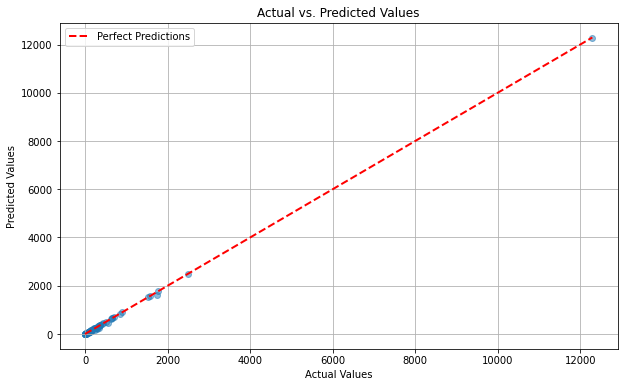

In [21]:
import matplotlib.pyplot as plt

# Create a scatter plot to visualize the actual vs. predicted values
plt.figure(figsize=(10, 6))
plt.scatter(y_test, predictions, alpha=0.5)
plt.title('Actual vs. Predicted Values')
plt.xlabel('Actual Values')
plt.ylabel('Predicted Values')
plt.grid(True)

# Add a line indicating perfect predictions
plt.plot([min(y_test), max(y_test)], [min(y_test), max(y_test)], linestyle='--', color='red', linewidth=2, label='Perfect Predictions')

plt.legend()
plt.show()

## VALIDATING THE MODEL RESULTS WITH THE ACTUAL DATA

In [23]:
# Split data into training, validation, and test sets
X_train, X_temp, y_train, y_temp = train_test_split(X_train, y_train, test_size=0.2, random_state=42)
X_val, X_test, y_val, y_test = train_test_split(X_temp, y_temp, test_size=0.5, random_state=42)

In [35]:
# Initialize an empty list to store training and validation losses
train_losses = []
val_losses = []

In [36]:
# Define a range of alpha values for Ridge regularization
alphas = [0.01, 0.1, 1.0, 10.0] 

In [39]:
for alpha in alphas:
    # Create a Ridge regression model with the current alpha value
    model = Ridge(alpha=alpha, random_state=42)

    # Fit the model
    model.fit(X_train, y_train)

    # Calculate training and validation losses
    train_predictions = model.predict(X_train)
    val_predictions = model.predict(X_val)

    train_loss = mean_squared_error(y_train, train_predictions)
    val_loss = mean_squared_error(y_val, val_predictions)

    train_losses.append(train_loss)
    val_losses.append(val_loss)

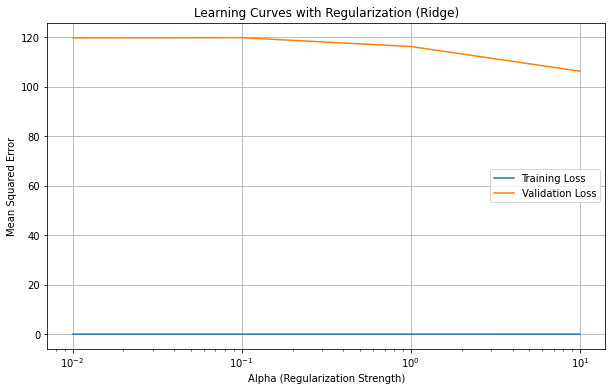

In [40]:
# Plot learning curves for different alpha values
plt.figure(figsize=(10, 6))
plt.plot(alphas, train_losses, label='Training Loss')
plt.plot(alphas, val_losses, label='Validation Loss')
plt.xlabel('Alpha (Regularization Strength)')
plt.ylabel('Mean Squared Error')
plt.legend()
plt.title('Learning Curves with Regularization (Ridge)')
plt.xscale('log')  # Use a logarithmic scale for alpha values
plt.grid(True)
plt.show()

In [41]:
# Choose the best alpha based on validation loss
best_alpha = alphas[np.argmin(val_losses)]
print(f"Best Alpha: {best_alpha}")

Best Alpha: 10.0


In [42]:
# Train the final model with the best alpha on the entire training set
final_model = Ridge(alpha=best_alpha, random_state=42)
final_model.fit(X_train, y_train)

Ridge(alpha=10.0, copy_X=True, fit_intercept=True, max_iter=None,
      normalize=False, random_state=42, solver='auto', tol=0.001)

In [43]:
#  Evaluate the final model on the test set
test_predictions = final_model.predict(X_test)
test_loss = mean_squared_error(y_test, test_predictions)
print(f"Test Loss with Regularization: {test_loss}")

Test Loss with Regularization: 4.555225012559398
